# Happiness score (model fine-tuning)

In this notebook, I aim to fine-tune the hyperparameters of a Random Forest Regressor, as it demonstrated the strongest predictive performance for the happiness score in `happiness_2.ipynb`. The dataset remains the same—adapted for machine learning purposes—but this time, I incorporate inflation-related features that were previously excluded. These additions are evaluated using both SHAP and feature importance visualizations to assess their relevance.

**Relevant Findings:**

The inclusion of inflation-related features did not significantly enhance model performance. Minor variations were observed in R-squared and RMSE metrics, but these were not substantial. Both feature importance rankings and SHAP visualizations consistently indicated that these variables had limited predictive value.


## Data preparation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# Load the raw file
filepath = 'data/WHI_Inflation.csv'
happy_raw = pd.read_csv(filepath)
print(happy_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 1232 non-null   object 
 1   Year                                    1232 non-null   int64  
 2   Headline Consumer Price Inflation       1200 non-null   float64
 3   Energy Consumer Price Inflation         1090 non-null   float64
 4   Food Consumer Price Inflation           1130 non-null   float64
 5   Official Core Consumer Price Inflation  734 non-null    float64
 6   Producer Price Inflation                769 non-null    float64
 7   GDP deflator Index growth rate          1211 non-null   float64
 8   Continent/Region                        1232 non-null   object 
 9   Score                                   1232 non-null   float64
 10  GDP per Capita                          1232 non-null   floa

In [ ]:
# Select relevant features (removed: the ones with high presence of outliers, not numerical, not needed)
inflation_features = happy_raw.drop(
    [
        'Official Core Consumer Price Inflation',
        'Producer Price Inflation',
        'Country',
        'Continent/Region',
        'Year'
    ],
    axis=1
).copy()

# Count nulls
print(inflation_features.isna().sum().sort_values(ascending=False))

Energy Consumer Price Inflation      142
Food Consumer Price Inflation        102
Headline Consumer Price Inflation     32
GDP deflator Index growth rate        21
Perceptions of corruption              1
GDP per Capita                         0
Score                                  0
Social support                         0
Healthy life expectancy at birth       0
Freedom to make life choices           0
Generosity                             0
dtype: int64


In [ ]:
# Impute nulls
imputer = KNNImputer(n_neighbors=5)

imputed_df = pd.DataFrame(
    imputer.fit_transform(inflation_features),
    columns=inflation_features.columns
)

# Print new df info
print(imputed_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Headline Consumer Price Inflation  1232 non-null   float64
 1   Energy Consumer Price Inflation    1232 non-null   float64
 2   Food Consumer Price Inflation      1232 non-null   float64
 3   GDP deflator Index growth rate     1232 non-null   float64
 4   Score                              1232 non-null   float64
 5   GDP per Capita                     1232 non-null   float64
 6   Social support                     1232 non-null   float64
 7   Healthy life expectancy at birth   1232 non-null   float64
 8   Freedom to make life choices       1232 non-null   float64
 9   Generosity                         1232 non-null   float64
 10  Perceptions of corruption          1232 non-null   float64
dtypes: float64(11)
memory usage: 106.0 KB
None


In [ ]:
# Save the new dataframe
imputed_df.to_csv('inflation_features.csv', index=False)

# Random forest regressor
The baseline model is the Random Forest Regressor previously used. Feature selection was guided by importances identified through a Lasso model—some of which reappear here alongside the inflation-related features. As noted earlier, the overall improvement is small.

**Summary of results**

| Metric           | Current Regressor   | Previous Regressor   |
|------------------|---------------------|----------------------|
| R²               | 0.7778              | 0.7741               |
| MAE              | 0.4024              | 0.4141               |
| RMSE             | 0.5232              | 0.5276               |

In [ ]:
# Random forest regressor

# Features and target
X = imputed_df.drop('Score', axis=1)
y = imputed_df['Score']

# Train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

# Model instantiation and fitting
forest = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
forest.fit(X_train, y_train)

# Predictions and model performance
predictions = forest.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'R²: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

R²: 0.7778
MAE: 0.4024
RMSE: 0.5232


## Visualizations

### Feature importance
The horizontal bar chart displays the relative importance of each feature in predicting the happiness score. Traditional predictors such as GDP per Capita, Healthy Life Expectancy and Social Support, dominate the ranking, reaffirming their central role in the model’s performance. However, features like Perception of Corruption and Generosity show more relative importance, in contrast with the results of the Lasso model.

Inflation-related variables, on the other hand, consistently rank lower, suggesting limited explanatory power in this context.

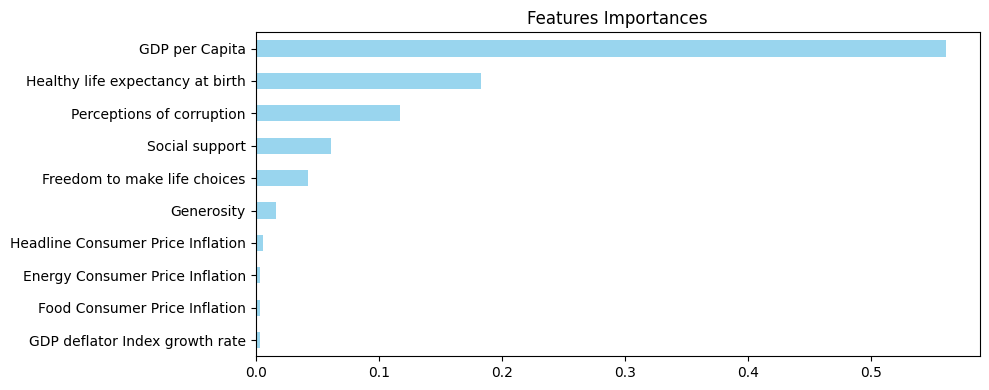

In [ ]:
# Feature importances

# Series of features importances
cols = X.columns
importances = pd.Series(
    data=forest.feature_importances_,
    index= cols
)

# Sort importances
importances_sorted = importances.sort_values()

# Barplot
importances_sorted.plot(
    kind='barh',
    color='skyblue',
    alpha=0.85,
    figsize=(10, 4),
    title='Features Importances'
)
plt.tight_layout()
plt.show()

### SHAP
The feature importance results align closely with the SHAP summary plot, which further illustrates the poor influence of inflation features on the predictions.

Happiness, at least in this dataset, remains more tightly linked to social and health-related factors than to short-term economic fluctuations.

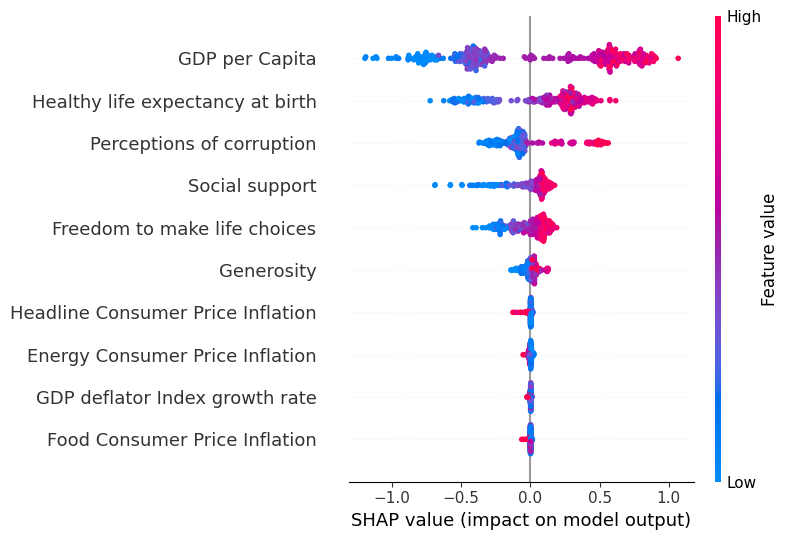

In [ ]:
import shap

# Initialize the explainer for tree-based models
explainer = shap.TreeExplainer(forest)

# Compute SHAP values (use test set for interpretation)
shap_values = explainer.shap_values(X_test)

# Summary plot (dot version —default—)
shap.summary_plot(shap_values, X_test)

# Fine-tuning
Feature importance and SHAP visualizations confirm that inflation-related variables do not contribute significantly to the model’s performance. As a result, these features are excluded from the fine-tuning process.

**Initial hyperparameters**

- `n_estimators = 100`
- `max_depth = 5`
- `min_samples_split = 5`

**Results**
- R²: 0.7724
- RMSE: 0.5294

In [ ]:
# Random forest regressor: only happiness-related features

# Initial hyperparameters
n_estimators = 100
max_depth = 5
min_samples_split = 5

# Features and target
X = imputed_df.drop(
    [
        'Score',
        'Headline Consumer Price Inflation',
        'Energy Consumer Price Inflation',
        'Food Consumer Price Inflation',
        'GDP deflator Index growth rate'
    ],
    axis=1)

y = imputed_df['Score']

# Train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

# Model instantiation and fitting
forest = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    random_state=42
)

forest.fit(X_train, y_train)

# Predictions and model performance
predictions = forest.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')

R²: 0.7724
RMSE: 0.5294


## Grid Search Cross-Validation

**Hyperparameters to modify**

- `n_estimators` → More trees, more stable predictions because of lower variance. List to search on: `[100, 250, 300]`.

- `max_depth` → Depth of a tree. It tunes the balance between bias (underfitting) and variance (overfitting). Range to search on: `(3, 11)`.

- `min_samples_split` → Prevents splits when a node has very few samples. Larger values reduce overfitting and keep low variance in nodes. Range to search on: `(4, 16)`.

An improvement was achieved: variance explanation of roughly 80%, average error of 0.4971 happiness points—both lower than any of the other metrics obtained so far.  

*⚠️ Note: the bigger the arrays of hyperparameters to search for, bigger the computational power required. Keep in mind that `cv` parameter definition can also slow down the process.*

**Results**

- `n_estimators = 300`
- `max_depth = 10`
- `min_samples_split = 4`
- `R² = 0.7993`
- `RMSE = 0.4971`

In [ ]:
from sklearn.model_selection import GridSearchCV

### Fine-tuning the model ###

# Model instantiation
forest = RandomForestRegressor(random_state=42)

# Define the parameters
params = {
    'n_estimators': [100, 250, 300],
    'max_depth': np.arange(3, 11),
    'min_samples_split': np.arange(4, 16)
}

# Instantiate the Grid object
grid = GridSearchCV(
    estimator=forest,
    param_grid=params,
    cv=3, # Number of cross-validations to perform
    verbose=1,
    n_jobs=-1 # Use all processors
)

# Fitting and prediction
grid.fit(X_train, y_train)
predictions = grid.predict(X_test)

# Scoring: RMSE
rmse = root_mean_squared_error(y_test, predictions)

# Best estimator
best_model = grid.best_estimator_

# Results
print('RMSE of best model: {:.4f}'.format(rmse))
print(best_model)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
RMSE of best model: 0.4971
RandomForestRegressor(max_depth=np.int64(10), min_samples_split=np.int64(4),
                      n_estimators=300, random_state=42)


In [ ]:
# Optimal parameters
result = {
    'n_estimators': 300,
    'max_depth': 10,
    'min_samples_split': 4
}

r2 = r2_score(y_test, predictions)
print(f'R²: {r2:.4f}')

R²: 0.7993


# Final Summary: Grid Search Optimization
Through exhaustive grid search and cross-validation, the Random Forest Regressor was fine-tuned to its most effective configuration. The optimal model—using 300 trees, a maximum depth of 10, and a minimum split threshold of 4—achieved an R² of 0.7993 and an RMSE of 0.4971, outperforming all previous models. Targeted hyperparameter tuning can yield meaningful improvements in predictive accuracy, even when baseline performance is already strong.

While inflation-related features were ultimately excluded, this process reaffirmed the dominance of social and health indicators in explaining happiness scores.